<a href="https://colab.research.google.com/github/nandresparra/miami_bootcamp/blob/master/01_Introduction_to_Exercise_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Covera Health Exercise for AI Computer Vision**

My approach to solve the problem has two components:


1.   A V-Net model was trained with images from Domain A to segment intra-vertebral discs
2.   An atlas-like approach is used to map the images from DomainB to DomainA. Given an image ***B*** from DomainB, all images from DomainA are registered to ***B***. The closest image in DomainA  to ***B*** (***Aclosest***) is selected as surrogate on DomainA 
1.   The V-net model is used to predict the segmentation of *B* using ***Aclosest*** as input to the neural network

The model assumes that all future images will be from DomainA or DomainB. Images from a substancially different domain will require a tailored atlas. Even images from DomainB with heavy distortions that can't be captured by the small atlas will fail to produce accurate segmentations.













# Unzipping the data
At this point, you have received the data.zip file back from me for your review. Thank you!

In [0]:
!unzip -q data.zip

Also, Colab do not have the SimpleITK package installed. Please install if need to.

In [6]:
!pip install SimpleITK

     |████████████████████████████████| 42.5MB 91kB/s 


# Structure of the .data directory
I have added the segmentations and the intermediate files to the provided data structure.

The requested segmentations can be found in **DomainBwithPredictions**

The pre-computed model, atlas, and spine segmentations can be found in **temp_precomputed** spine segmentations and atlas.

All intermediate files that you create are saved in .data/temp 

    data 
        Training 
            DomainA
            DomainB
            DomainBwithPredictions
        temp 
        temp_precomputed
            model 
            spine_seg 
            atlas 


# Loading the data and Computing the matrices for future processing

Let's import all the module needed. Since the data sets are small we are processing them in matrix form for future computations

In [1]:
import data_
from utils import imshow
from data_preproc import getAllData, getMatrices, getBestInAtlas, loadDataAndLabel
from vnet_train import trainModel
from spine_seg3D import doSpineSegmentation
from atlas_registration import createAtlas
import os

domain = 'DomainA'
path_A = './data/Training/' + domain
train_dict = getAllData(path_A, doPlot=False)

domain = 'DomainB'
path_B = './data/Training/' + domain
test_dict = getAllData(path_B, doPlot=False)

X, y = getMatrices(train_dict)
X_test, _ = getMatrices(test_dict)

./data
{'train': [], 'valid': []}
n_patients 8
n_patients 4


#Building and training the model
To create and train a new V-Net please uncomment the last line below and run trainModel. To use the full data set as training set, please set *doFinalize*=**True**.

Give it a try. The network converges even with only 6 input images!
We augment the whole training set at every iteration using bspline deformations, so the network sees a lot more images...

In [10]:
from vnet_train import trainModel

model_path = './data/temp/model'

#Please uncomment this line to train 
#vnet_model = trainModel(X, y, model_path, n_epochs=2000, doFinalize=False)

Model: "model_3"
_____________________________________________________________________________________________________________________________________
Layer (type)                               Output Shape                  Param #         Connected to                                
input_4 (InputLayer)                       [(None, 128, 128, 64, 1)]     0                                                           
_____________________________________________________________________________________________________________________________________
conv3d_81 (Conv3D)                         (None, 128, 128, 64, 16)      2016            input_4[0][0]                               
_____________________________________________________________________________________________________________________________________
c1 (Concatenate)                           (None, 128, 128, 64, 16)      0               input_4[0][0]                               
                                             

KeyboardInterrupt: ignored

# Loading the pre-trained module
If you don't have the time, please load the pre-computed module...

In [2]:
from tensorflow.keras.models import model_from_json

model_path = './data/temp_precomputed/model'

topology_path = os.path.join(model_path,'NOT_FINALIZED')
json_file = open(os.path.join(topology_path,'model.json'), 'r')
loaded_model_json = json_file.read()
json_file.close()
vnet_model = model_from_json(loaded_model_json)
vnet_model.load_weights(os.path.join(topology_path,'model_e2000.h5'))
print("Loaded model from disk")
vnet_model.summary(line_length=133)

Loaded model from disk
Model: "model"
_____________________________________________________________________________________________________________________________________
Layer (type)                               Output Shape                  Param #         Connected to                                
input_1 (InputLayer)                       [(None, 128, 128, 64, 1)]     0                                                           
_____________________________________________________________________________________________________________________________________
conv3d (Conv3D)                            (None, 128, 128, 64, 16)      2016            input_1[0][0]                               
_____________________________________________________________________________________________________________________________________
c1 (Concatenate)                           (None, 128, 128, 64, 16)      0               input_1[0][0]                               
                        

#Preparing the data from DomainB for predictions
The train model fails with images from DomainB (I tried...)
To overcome this limitation we create an image that has a similar anatomical information for an image from DomainB, but looks like one from DomainA.

This includes segmenting the spine to guide the registration by masking the area we are interested in. Then we build de atlas and we are ready to make predictions.
The segmentations are done quickly. RUn the code and you will see how one of them looks like.
The atlas creating takes a long of time. Please uncomment if you have the resources.

In [18]:
segment_path = './data/temp/spine_seg'
atlas_path = './data/temp/atlas'
doSpineSegmentation(y, segment_path)
#createAtlas(X, y, X_test, segment_path, atlas_path)

m_id 00


IndexError: ignored

#Using precomputed spine segmentations and atlas
If you want to use the precomputed atlas just set the appropriate paths

In [20]:
segment_path = './data/temp_precomputed/spine_seg'
createAtlas(X, y, X_test, segment_path, atlas_path)
atlas_path = './data/temp_precomputed/atlas'
doSpineSegmentation(y, segment_path)


-------
itk::simple::Transform
 Euler3DTransform (0xbe742940)
   RTTI typeinfo:   itk::Euler3DTransform<double>
   Reference Count: 3
   Modified Time: 4960311
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.999944 -0.00384971 0.00984663 
     0.00298311 0.996242 0.0865576 
     -0.0101429 -0.0865234 0.996198 
   Offset: [-0.0653957, -2.67587, 6.25739]
   Center: [63.5, 63.5, 31.5]
   Translation: [-0.00323275, 0.00151173, -0.000676047]
   Inverse: 
     0.999944 0.00298311 -0.0101429 
     -0.00384971 0.996242 -0.0865234 
     0.00984663 0.0865576 0.996198 
   Singular: 0
   Euler's angles: AngleX=-0.0866317 AngleY=0.0101812 AngleZ=0.00386422
   m_ComputeZYX = 0

Optimizer stop condition: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.
 Iteration: 9
 Metric value: -0.13435575057241433


SystemError: ignored

#Making predictions
We are ready to make our predictions. For each image in DomainB, We find its surrogate image in the atlas and feed it to the V-Net model!

In [0]:
midz=32
atlas_size = X.shape[0]
setB = loadDataAndLabel(path_B)
predictions = {}
for b,k in enumerate(sorted(setB.keys())):
    imageB = setB[k][0]
    atlas_surrogate = getBestInAtlas(X_test[b], b, atlas_size, atlas_path)
    y_hat = vnet_model.predict(atlas_surrogate, batch_size=1)
    predictions[k] = y_hat

To save the predictions...

(36, 256, 256) (36, 256, 256)


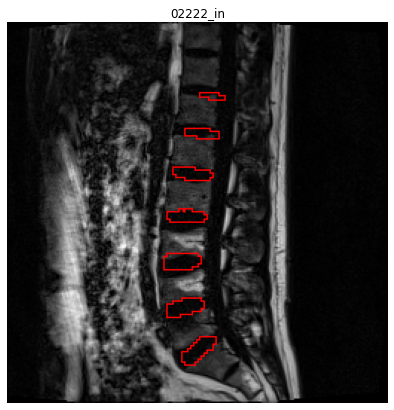

(36, 256, 256) (36, 256, 256)


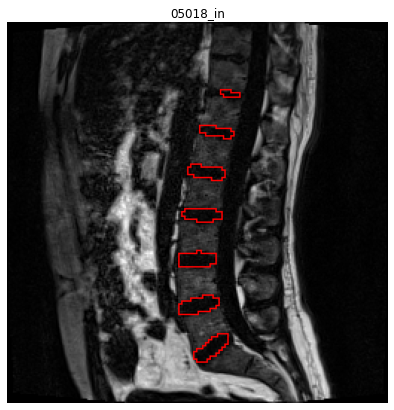

(36, 256, 256) (36, 256, 256)


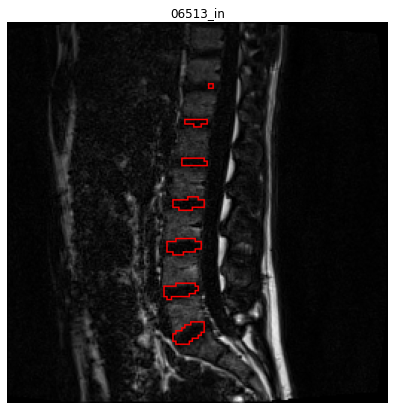

(36, 256, 256) (36, 256, 256)


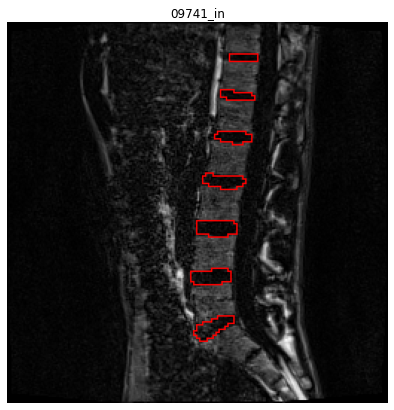

In [12]:
import numpy as np
from scipy.ndimage import zoom
midz = 18
for k in predictions.keys():
    imageB = setB[k][0]
    y_hat = predictions[k]
    y_hat_save = y_hat[0,:,:,:,1].astype(np.int8)
    y_hat_save = np.transpose(y_hat_save, [2,0,1])
    y_hat_save = zoom(y_hat_save, (36/64,2,2), order=0)

    print(imageB.shape, y_hat_save.shape)
    imshow(imageB[midz,:,:,np.newaxis],y_hat_save[midz,:,:,np.newaxis], title=k )
    y_hat_save.tofile(os.path.join(path_B,k,'lbl.npy'))

To check the predictions:

In [89]:
import data_
from utils import imshow

domain = 'DomainB'
path = './data/Training/' + domain
data_.set_root(path)

./data/Training/DomainB
{'train': [{'studyid': '05018_in', 'mean': 52.85391974082875, 'sd': 66.34762714826368}, {'studyid': '02222_in', 'mean': 51.66286219989152, 'sd': 67.66548932319007}, {'studyid': '06513_in', 'mean': 26.01724103208023, 'sd': 39.94973143155}], 'valid': [{'studyid': '09741_in', 'mean': 24.394733052778346, 'sd': 34.07340648235497}]}


./data/Training/DomainB/06513_in/dat.npy


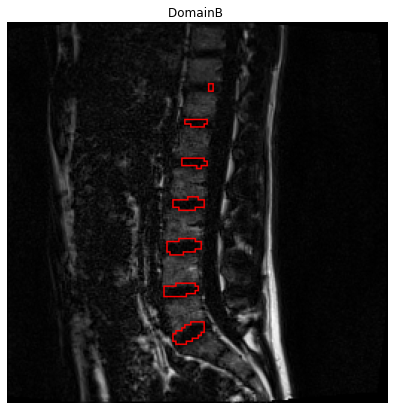

In [90]:
dat, lbl = data_.load(mode='train')
imshow(dat[..., 0], lbl=lbl if lbl.any() else None, title='DomainB ')

#Uncertainty of the model
One of the nice things of V-Net representaton is that you can use the (negative) DICE coefficient as loss function and also as a measure of accuracy. 
Using six images for training and two for validation, the training DICE was 0.90 and the validation DICE was 0.85 (see figure below). This tell us something about the behavior of the model with unseen data.

The atlas construction has more uncertainty than the V-net prediction. It is not a robust atlas and it is highly uncertain that will work with other images.

#What else would I've done?
This was an interesting experience. I would definitely work in creating a better atlas. Once we have generated several matching pairs of images from DomainA and DomainB, I would try to build a CNN that would map images from different domains without requiring an atlas. There are several examples online of mapping of MRI to CT... Something to think about

That's it!
I hope you enjoyed. Hopefully I am not doing something seriously wrong. I am looking forward to getting your feedback.